In [30]:
import numpy as np
import trace_gen as tg
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
import scipy.stats as ss

In [47]:
def load_trace_w(file):
    w = np.loadtxt(f'/opt/traces/{file}_r.txt', dtype=np.int32)
    w[:, 0] += 7
    w = tg.squash(tg.unroll(w // 8))
    return w

def load_trace_v(file):
    v = np.loadtxt(f'/mnt/sda/alibaba_block_traces_2020/{file}.txt', dtype=np.int64)
    v[:, 0] += 4095
    v = tg.squash(tg.unroll(v // 4096))
    return v

def type_b_run(w): 
    r = tg.TraceReconstructor(w)
    recon_w = r.gen_from_ird(len(w)//3)
    return recon_w

def type_b_run2(w, n): 
    r = tg.TraceReconstructor(w)
    recon_w = r.gen_from_ird(n)
    return recon_w

def type_a_run(M, n, f, p_irm):
    g = tg.TraceGenerator(M, n)
    recon_t = g.gen_from_pdf(f, p_irm)
    return recon_t
    
def mrc(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K//2)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def calculate_error(reference, comparison):
    # Example error metric: Mean Absolute Error (MAE)
    if len(reference) > len(comparison):
        comparison = np.interp(np.linspace(0, 1, len(reference)), np.linspace(0, 1, len(comparison)), comparison)
    else:
        reference = np.interp(np.linspace(0, 1, len(comparison)), np.linspace(0, 1, len(reference)), reference)
    return np.mean(np.abs(reference - comparison))

def plot_mrcs(cs, lrus, names, title, location='upper left'):
    cs_normalized = [c / c.max() for c in cs]
    palette = sns.color_palette()
    fig, ax = plt.subplots()

    # Calculate error metrics
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1:
            linestyle = '--'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]}"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=24)
    ax.set_ylabel('Hit rate', fontsize=24)
    ax.legend(loc=location, fontsize=17, framealpha=0)
    ax.set_title(title, fontsize=24)
    ax.tick_params(axis='both',  labelsize=20)

    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))

    plt.show()



In [5]:
f82 = tg.fgen(100, [12,13,19],1e-3)

In [6]:
import multiprocessing
import psutil
import time
import os

def monitor(func, *args):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    def target(return_dict, idx, *args):
        process = psutil.Process(os.getpid())
        print(f"Process ID: {os.getpid()}")
        
        start_time = time.time()
        
        result = func(*args) 
        
        end_time = time.time()
        
        # # CPU times
        # cpu_times = process.cpu_times()
        # user_time = cpu_times.user
        # system_time = cpu_times.system

        # Memory usage in MB
        memory_info = process.memory_info()
        memory_usage = memory_info.rss / 1024 ** 2  # Convert from bytes to MB

        # Elapsed time
        elapsed_time = end_time - start_time

        # Print the resource usage
        print(f"Memory Usage: {memory_usage:.2f} MB")
        # print(f"User Time: {user_time:.2f} seconds")
        # print(f"System Time: {system_time:.2f} seconds")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")

        # Store the result in the shared dictionary
        return_dict[idx] = result

    # Run the target function in a new process
    p = multiprocessing.Process(target=target, args=(return_dict, 0, *args))
    p.start()
    p.join()

    # Retrieve the result from the shared dictionary
    return return_dict[0]


In [7]:
w82 = load_trace_w('w82')

In [8]:
tb_w82 = monitor(type_b_run, w82)# use trace length // 3 for this measurement, but the actual plot of MRC later on uses the trace we created before with length // 2, due to the shorter trace doesn not capture the full MRC.

Process ID: 8365


Memory Usage: 226.38 MB
Elapsed Time: 36.74 seconds


In [9]:
ta1_w82 = monitor(type_a_run, 100, 10000, f82, 0.2)


Process ID: 8390


Memory Usage: 195.88 MB
Elapsed Time: 0.06 seconds


In [79]:
co, hro = mrc(w82)
co_tb, hro_tb = mrc(tb_w82)
co_ta1, hro_ta1 = mrc(ta1_w82)


In [80]:
ta2_w82 = monitor(type_a_run, 1000, 100000, f82, 0.2)
co_ta2, hro_ta2 = mrc(ta2_w82)
ta3_w82 = monitor(type_a_run, 10000, 1000000, f82, 0.2)
co_ta3, hro_ta3 = mrc(ta3_w82)

Process ID: 9103


Memory Usage: 454.31 MB
Elapsed Time: 0.60 seconds
Process ID: 9127
Memory Usage: 455.88 MB
Elapsed Time: 6.22 seconds


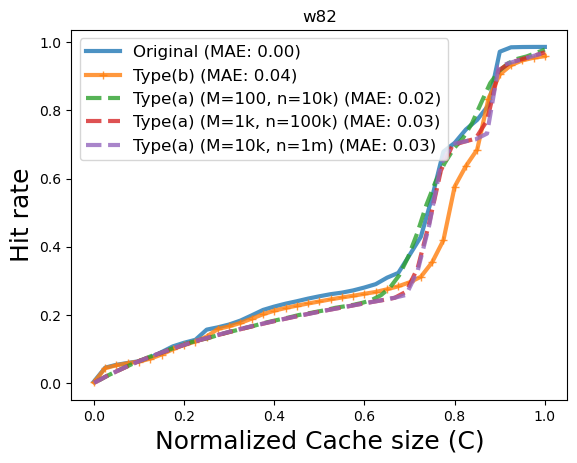

In [39]:
plot_mrcs([co, co_tb, co_ta1, co_ta2, co_ta3], [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'], 'w82')


In [3]:
def plot_mrc_cost(cs, lrus, names, location='upper left', gen_mem=None, gen_time=None):
    cs_normalized = [c / c.max() for c in cs]
    palette_mrcs = sns.color_palette()  # Default palette for MRCs
    palette_mem_time = sns.color_palette("dark")  # "dark" palette for Memory and Time usage
    
    # Create a figure with two subplots: one for the MRCs and one for the memory/time usage
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plotting the MRCs
    ax = axs[0]
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1 or i == 2:
            linestyle = '-'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]} (MAE: {errors[i]:.2f})"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette_mrcs[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=18)
    ax.set_ylabel('Hit rate', fontsize=18)
    ax.legend(loc=location, fontsize=14)
    ax.set_title("MRCs", fontsize=18)
    
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
    
    # Plotting the memory and time usage
    ax2 = axs[1]
    indices = np.arange(len(gen_mem))
    bar_width = 0.35
    
    bars1 = ax2.bar(indices, gen_mem, bar_width, label='Memory (MB)', alpha=0.7, color=palette_mem_time[0])
    ax2.set_xlabel('Trace-generation Type', fontsize=18)
    ax2.set_ylabel('Memory (MB)', fontsize=18)
    ax2.set_title('Memory and Time Usage', fontsize=18)
    ax2.set_xticks(indices)
    ax2.set_xticklabels(names[1:], rotation=20, ha='right', fontsize=12)
    
    # Add a second y-axis for time usage
    ax3 = ax2.twinx()
    ax3.plot(indices, gen_time, label='Time (s)', marker='o', linestyle='-', linewidth=2, color=palette_mem_time[1])
    ax3.set_ylabel('Time (s)', fontsize=18)
    
    # Combine legends from ax2 and ax3
    handles_mem = [bars1]  # Memory usage bar
    handles_time, labels_time = ax3.get_legend_handles_labels()

    handles_combined = handles_mem + handles_time
    labels_combined = ['Memory (MB)'] + labels_time
    
    ax2.legend(handles_combined, labels_combined, loc='upper right', fontsize=14, bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()


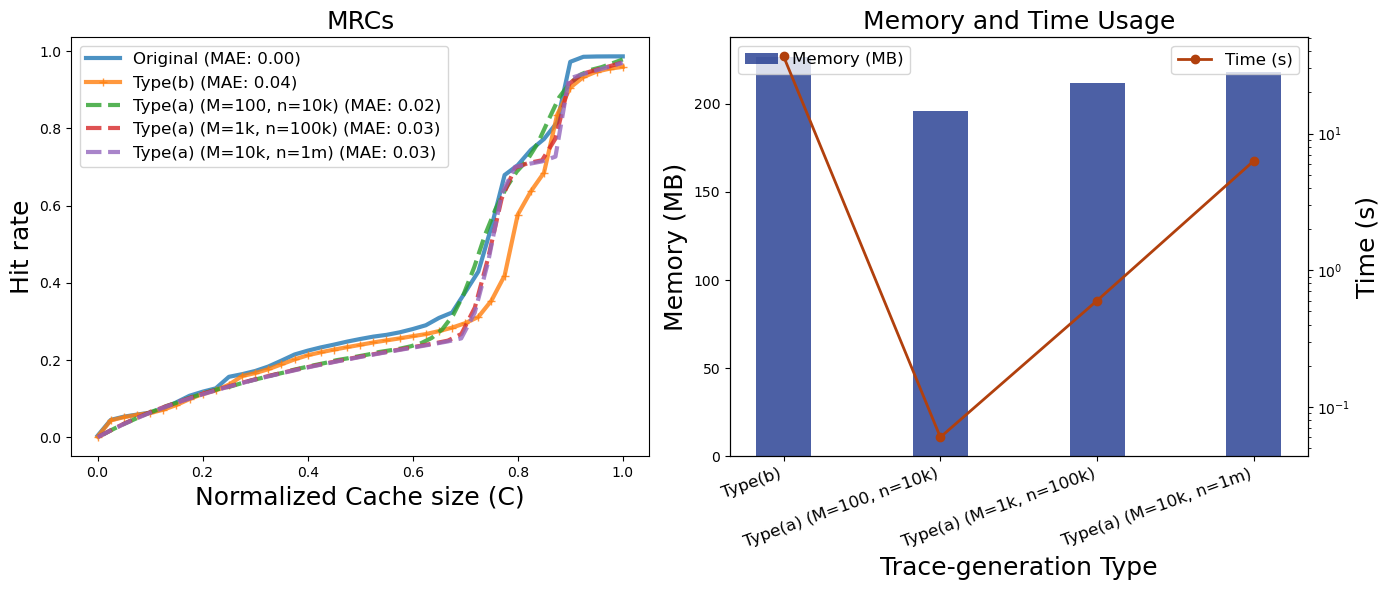

In [81]:

# Example usage:
w82_gen_mem = [226.38, 195.88, 211.73, 218.11]
w82_gen_time = [36.74, 0.06, 0.60, 6.32]

plot_mrc_cost([co, co_tb, co_ta1, co_ta2, co_ta3], 
          [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], 
          ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
          location='best',
          w82_gen_mem=w82_gen_mem, 
          w82_gen_time=w82_gen_time)



In [ ]:
# w44, w82, v521, v538, v766

In [66]:
# w44
w44 = load_trace_w('w44')
tb_w44 = monitor(type_b_run, w44)

Process ID: 8740
Memory Usage: 500.43 MB
Elapsed Time: 115.27 seconds


In [71]:
f44 = tg.fgen(30, [9,13,17,19],2.5e-2)
ta1_w44 = monitor(type_a_run, 100, 10000, f44, 0)


Process ID: 8913


Memory Usage: 432.77 MB
Elapsed Time: 0.03 seconds


In [72]:
ta2_w44 = monitor(type_a_run, 1000, 100000, f44, 0)
ta3_w44 = monitor(type_a_run, 10000, 1000000, f44, 0)

Process ID: 8937


Memory Usage: 432.82 MB
Elapsed Time: 0.30 seconds
Process ID: 8961
Memory Usage: 434.47 MB
Elapsed Time: 3.15 seconds


In [75]:

w44_gen_mem = [500.43, 432.75, 432.81, 432.83]
w44_gen_time = [115.27, 0.03, 0.30, 3.15]
co, hro = mrc(w44)
co_tb = np.loadtxt(f'../data/recon/w44_c.txt', dtype=np.int32)
hro_tb = np.loadtxt(f'../data/recon/w44_ird_recon_lru_hr.txt', dtype=np.float32)
co_ta1, hro_ta1 = mrc(ta1_w44)
co_ta2, hro_ta2 = mrc(ta2_w44)
co_ta3, hro_ta3 = mrc(ta3_w44)


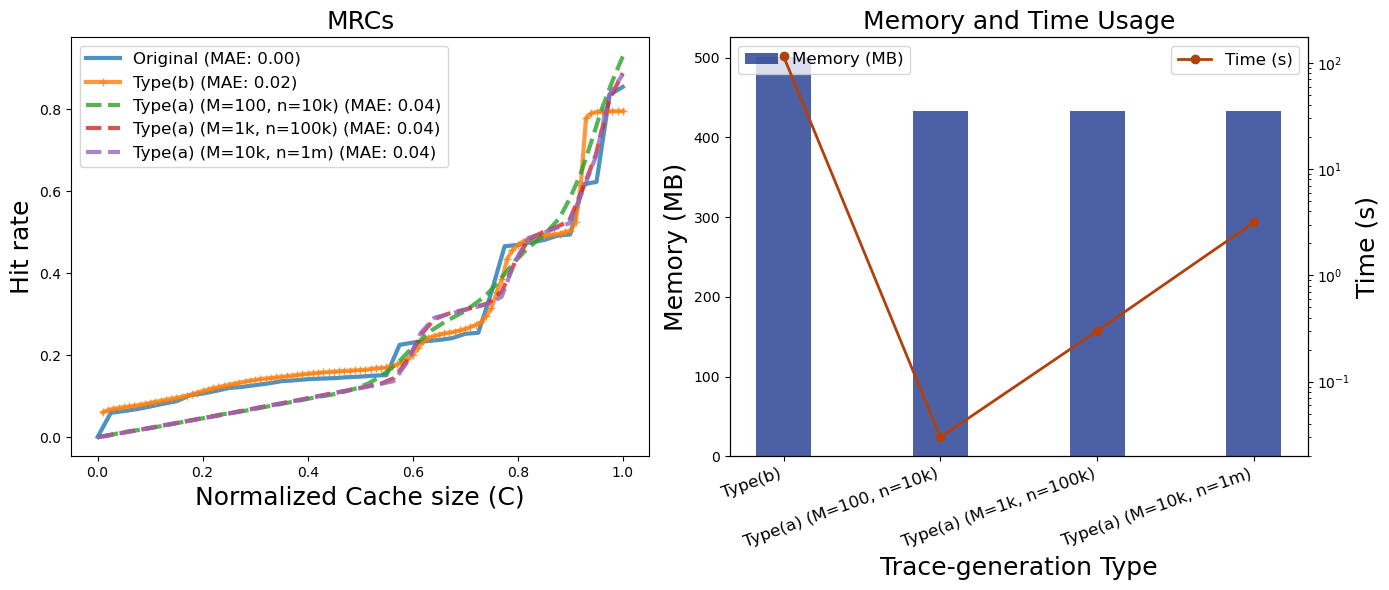

In [78]:
plot_mrc_cost([co, co_tb, co_ta1, co_ta2, co_ta3], 
          [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], 
          ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
          location='best',
          w82_gen_mem=w44_gen_mem, 
          w82_gen_time=w44_gen_time)

In [83]:
# v538
def parse_trace(file, start_row, num_rows):
    file_path = f'/mnt/sda/alibaba_block_traces_2020/{file}.txt'
    
    # Print file path for debugging
    print(f"Reading file: {file_path}")
    
    # Try to load the data
    try:
        trace = np.loadtxt(file_path, skiprows=start_row, max_rows=num_rows, dtype=np.int64)
    except Exception as e:
        print(f"Error reading the file: {e}")
        raise
    
    # Print the shape of the trace array
    print(f"Shape of trace array: {trace.shape}")
    
    # Check if trace is 2D
    if trace.ndim != 2 or trace.shape[1] < 2:
        raise ValueError(f"Expected 2D array with at least 2 columns, but got shape {trace.shape}")
    
    trace[:, 0] += 4095
    trace = tg.squash(tg.unroll(trace // 4096))
    return trace

v538 = parse_trace('volume538', 0, 1000000)
tb_v538 = monitor(type_b_run, v538)

Reading file: /mnt/sda/alibaba_block_traces_2020/volume538.txt
Shape of trace array: (1000000, 2)
Process ID: 9207
Memory Usage: 5585.68 MB
Elapsed Time: 579.63 seconds


In [3]:
import multiprocessing
import psutil
import time
import os

def monitor(func, *args):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    def target(return_dict, idx, *args):
        process = psutil.Process(os.getpid())
        print(f"Process ID: {os.getpid()}")
        
        start_time = time.time()
        
        result = func(*args) 
        
        end_time = time.time()

        memory_info = process.memory_info()
        memory_usage = memory_info.rss / 1024 ** 2  # Convert from bytes to MB

        elapsed_time = end_time - start_time

        print(f"Memory Usage: {memory_usage:.2f} MB")
        # print(f"User Time: {user_time:.2f} seconds")
        # print(f"System Time: {system_time:.2f} seconds")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")

        # Store the result in the shared dictionary
        return_dict[idx] = result

    p = multiprocessing.Process(target=target, args=(return_dict, 0, *args))
    p.start()
    p.join()

    return return_dict[0]

In [5]:
w44 = load_trace_w('w44')
w44_tb = monitor(type_b_run2, w44, 1000000)

Process ID: 5907
Memory Usage: 288.22 MB
Elapsed Time: 35.84 seconds


In [6]:
np.savetxt(f'../data/performance/w44_tb_1m.txt', w44_tb, fmt='%d')

In [7]:
f44 = tg.fgen(30, [9,13,17,19],2.5e-2)
ta1_w44 = monitor(type_a_run, 100, 10000, f44, 0)
ta2_w44 = monitor(type_a_run, 1000, 100000, f44, 0)
ta3_w44 = monitor(type_a_run, 10000, 1000000, f44, 0)
np.savetxt(f'../data/performance/w44_ta_10k.txt', ta1_w44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_100k.txt', ta2_w44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_1m.txt', ta3_w44, fmt='%d')

Process ID: 6177
Memory Usage: 261.45 MB
Elapsed Time: 0.03 seconds
Process ID: 6201
Memory Usage: 261.51 MB
Elapsed Time: 0.29 seconds
Process ID: 6225
Memory Usage: 262.50 MB
Elapsed Time: 3.04 seconds


In [8]:
c_44, hr_44 = mrc(w44)
c_tb_44, hr_tb_44 = mrc(w44_tb)
c_ta1_44, hr_ta1_44 = mrc(ta1_w44)
c_ta2_44, hr_ta2_44 = mrc(ta2_w44)
c_ta3_44, hr_ta3_44 = mrc(ta3_w44)
np.savetxt(f'../data/performance/w44_hr.txt', hr_44, fmt='%f')
np.savetxt(f'../data/performance/w44_tb_hr.txt', hr_tb_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_10k_hr.txt', hr_ta1_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_100k_hr.txt', hr_ta2_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_1m_hr.txt', hr_ta3_44, fmt='%f')
np.savetxt(f'../data/performance/w44_c.txt', c_44, fmt='%d')
np.savetxt(f'../data/performance/w44_tb_c.txt', c_tb_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_10k_c.txt', c_ta1_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_100k_c.txt', c_ta2_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_1m_c.txt', c_ta3_44, fmt='%d')

In [15]:
tbl_w44 = monitor(type_b_run2, w44, len(w44)//2)

Process ID: 6418
Memory Usage: 403.70 MB
Elapsed Time: 167.05 seconds


In [16]:
np.savetxt(f'../data/performance/w44_tb_len2.txt', tbl_w44, fmt='%d')
c_tbl_44, hr_tbl_44 = mrc(tbl_w44)
np.savetxt(f'../data/performance/w44_tb_len2_hr.txt', hr_tbl_44, fmt='%f')
np.savetxt(f'../data/performance/w44_tb_len2_c.txt', c_tbl_44, fmt='%d')

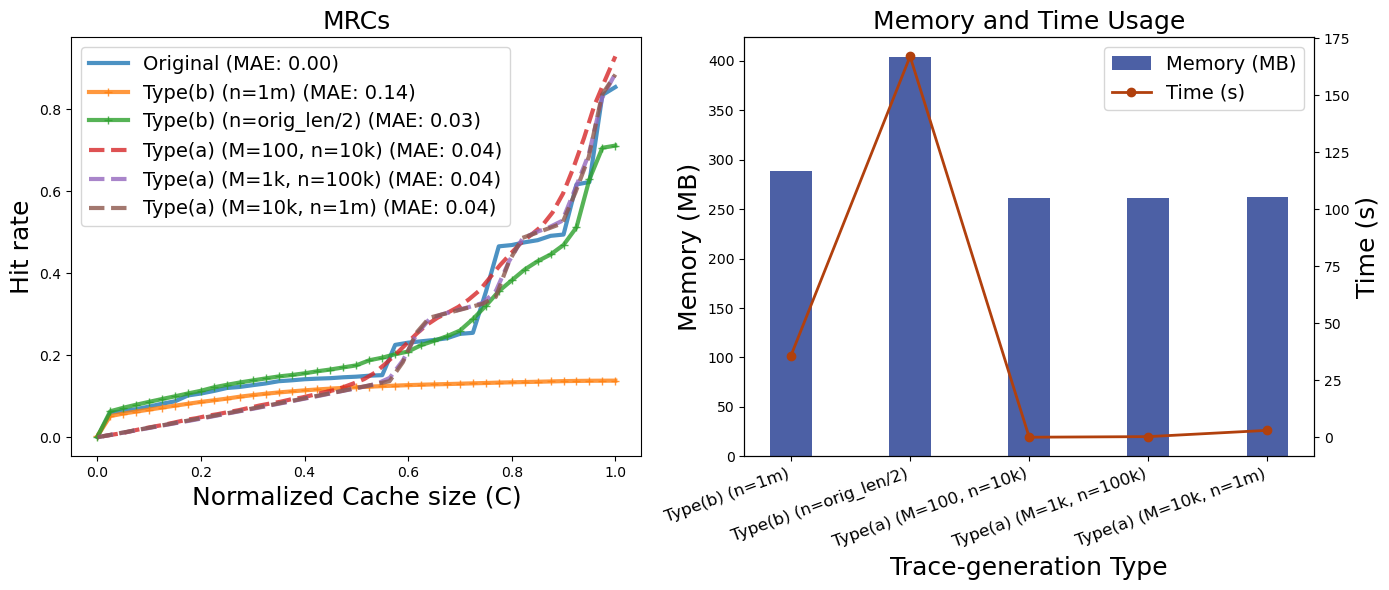

In [6]:
w44_gen_mem = [288.22, 403.70, 261.45, 261.51, 262.50]
w44_gen_time = [35.84, 167.05, 0.03, 0.29, 3.04]
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_cost([c_44, c_tb_44, c_tbl_44, c_ta1_44, c_ta2_44, c_ta3_44],
            [hr_44, hr_tb_44, hr_tbl_44, hr_ta1_44, hr_ta2_44, hr_ta3_44],
            ['Original', 'Type(b) (n=1m)', 'Type(b) (n=orig_len/2)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
            location='best',
            gen_mem=w44_gen_mem, 
            gen_time=w44_gen_time)

In [9]:
w82 = load_trace_w('w82')
# tb_w82_1m = monitor(type_b_run2, w82, 1000000)
# np.savetxt(f'../data/performance/w82_tb_1m.txt', tb_w82_1m, fmt='%d')

In [36]:
tbl_w82 = monitor(type_b_run2, w82, len(w82)//2)
np.savetxt(f'../data/performance/w82_tb_len2.txt', tbl_w82, fmt='%d')

Process ID: 6587
Memory Usage: 472.19 MB
Elapsed Time: 52.84 seconds


In [38]:
f82 = tg.fgen(100, [12,13,19],1e-3)
ta1_w82 = monitor(type_a_run, 100, 10000, f82, 0.2)
ta2_w82 = monitor(type_a_run, 1000, 100000, f82, 0.2)
ta3_w82 = monitor(type_a_run, 10000, 1000000, f82, 0.2)
np.savetxt(f'../data/performance/w82_ta_10k.txt', ta1_w82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_100k.txt', ta2_w82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_1m.txt', ta3_w82, fmt='%d')

Process ID: 6703


Memory Usage: 464.96 MB
Elapsed Time: 0.06 seconds
Process ID: 6729
Memory Usage: 465.00 MB
Elapsed Time: 0.61 seconds
Process ID: 6753
Memory Usage: 465.84 MB
Elapsed Time: 6.22 seconds


In [39]:
c_82, hr_82 = mrc(w82)
c_tb_82, hr_tb_82 = mrc(tb_w82_1m)
c_tbl_82, hr_tbl_82 = mrc(tbl_w82)
c_ta1_82, hr_ta1_82 = mrc(ta1_w82)
c_ta2_82, hr_ta2_82 = mrc(ta2_w82)
c_ta3_82, hr_ta3_82 = mrc(ta3_w82)
np.savetxt(f'../data/performance/w82_hr.txt', hr_82, fmt='%f')
np.savetxt(f'../data/performance/w82_tb_1m_hr.txt', hr_tb_82, fmt='%f')
np.savetxt(f'../data/performance/w82_tb_len2_hr.txt', hr_tbl_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_10k_hr.txt', hr_ta1_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_100k_hr.txt', hr_ta2_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_1m_hr.txt', hr_ta3_82, fmt='%f')
np.savetxt(f'../data/performance/w82_c.txt', c_82, fmt='%d')
np.savetxt(f'../data/performance/w82_tb_1m_c.txt', c_tb_82, fmt='%d')
np.savetxt(f'../data/performance/w82_tb_len2_c.txt', c_tbl_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_10k_c.txt', c_ta1_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_100k_c.txt', c_ta2_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_1m_c.txt', c_ta3_82, fmt='%d')



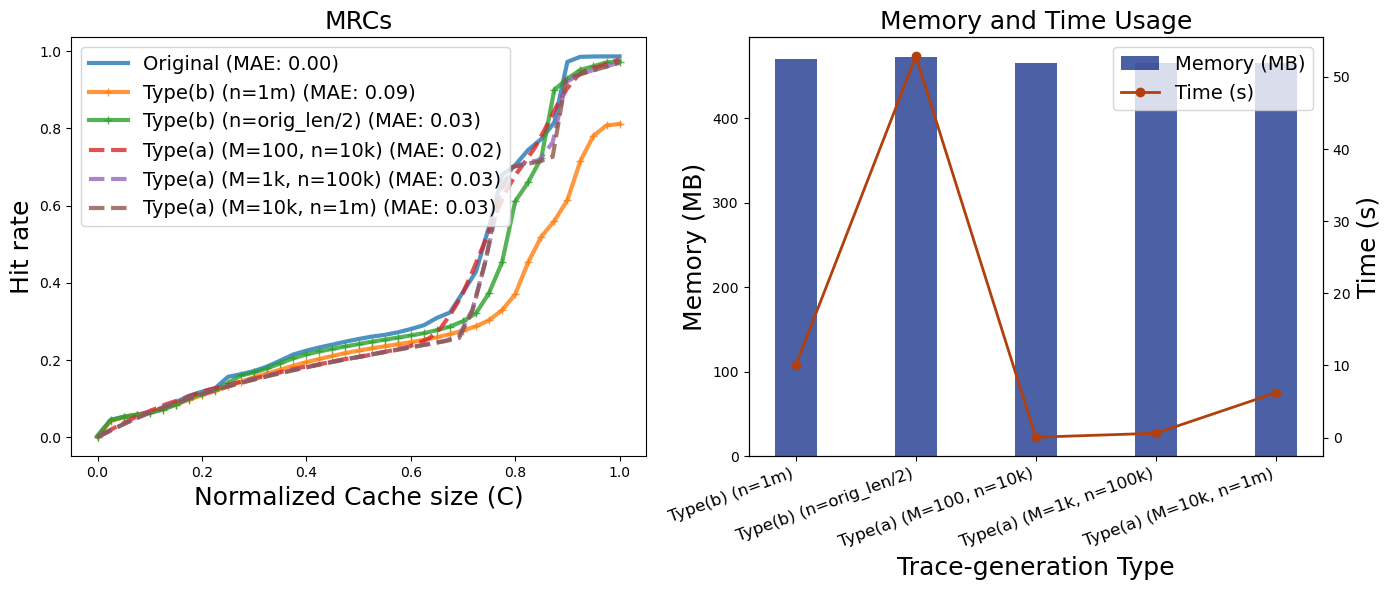

In [7]:
w82_gen_mem = [470.17,472.19,464.9,465.00,465.84]
w82_gen_time = [10.03,52.84,0.06,0.61,6.22]
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)

plot_mrc_cost([c_82, c_tb_82, c_tbl_82, c_ta1_82, c_ta2_82, c_ta3_82],
            [hr_82, hr_tb_82, hr_tbl_82, hr_ta1_82, hr_ta2_82, hr_ta3_82],
            ['Original', 'Type(b) (n=1m)', 'Type(b) (n=orig_len/2)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
            location='best',
            gen_mem=w82_gen_mem, 
            gen_time=w82_gen_time)

In [10]:
len(w82)

14198758

#### Type (b) does not scale well
- Need long enough trace to capture "full-resolution" of the MRC;
- Long enough trace is expensive to generate;
- Not long enough trace costs more than type (a) for the same length, but low accuracy.
#### Type (b) spends more time overall
-  Evidently even for generating the same length 1m with Type (a), but significantly lower accuracy.
#### Type (a) gen scales well
- Use the same set of parameter $\theta$ that is customized for M=100, n=10k, scales well;
- Could further increase accuracy by adjusting parameter $\theta$ for different scale.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_mrc_time(cs, lrus, names, location='upper left', gen_time=None):
    cs_normalized = [c / c.max() for c in cs]
    palette_mrcs = sns.color_palette()  # Default palette for MRCs
    palette_time = sns.color_palette("dark")  # "dark" palette for Time usage
    
    # Create a figure with two subplots: one for the MRCs and one for the time usage
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plotting the MRCs
    ax = axs[0]
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1:
            linestyle = '-'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]} (MAE: {errors[i]:.2f})"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette_mrcs[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=24)
    ax.set_ylabel('Hit rate', fontsize=24)
    ax.legend(loc=location, fontsize=15)
    ax.set_title("MRCs", fontsize=24)
    
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
    
    # Plotting the runtime usage
    ax2 = axs[1]
    indices = np.arange(len(gen_time))  # Ensure this covers all gen_time
    markers = ['o', 's', 'D', 'v', 'p']
    colors = sns.color_palette("dark", len(gen_time))  # Ensure enough colors for each gen_time
    
    for i in range(len(gen_time)):
        ax2.plot(indices[i], gen_time[i], label=names[i+1], marker=markers[i % len(markers)], linestyle='', linewidth=2,
                 color=colors[i-1], markersize=18, alpha=0.5)

    ax2.set_xlabel('Trace-gen Type', fontsize=24)
    ax2.set_ylabel('Run Time (sec)', fontsize=24)
    ax2.set_title('CPU Usage', fontsize=24)
    ax2.set_xticks(indices)
    # ax2.set_xticklabels(names[1:], rotation=0, ha='right', fontsize=12)
    ax2.legend(loc='upper right', fontsize=18)

    plt.tight_layout()
    plt.show()


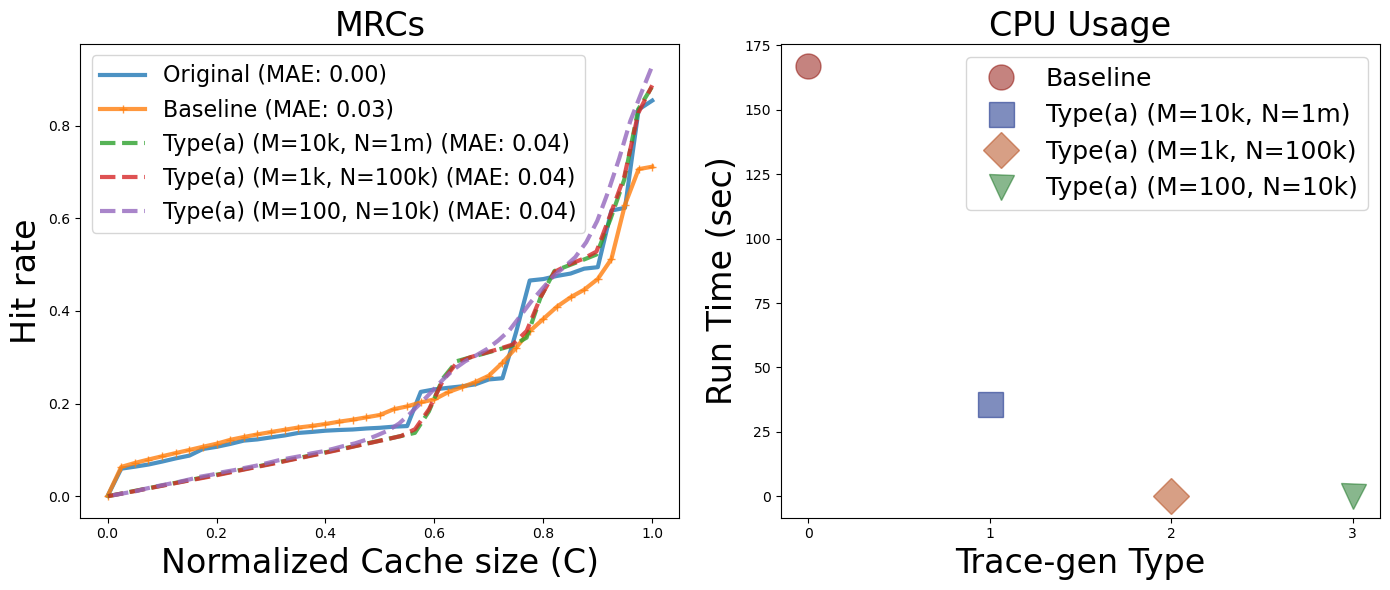

In [26]:

# w44_gen_time = [35.84, 167.05, 0.03, 0.29, 3.04]
w44_gen_time = [167.05, 35.84, 0.29, 0.03]
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
# c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
# hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_time([c_44, c_tbl_44, c_ta3_44, c_ta2_44, c_ta1_44], [hr_44, hr_tbl_44, hr_ta3_44, hr_ta2_44, hr_ta1_44], ['Original', 'Baseline', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], gen_time=w44_gen_time)

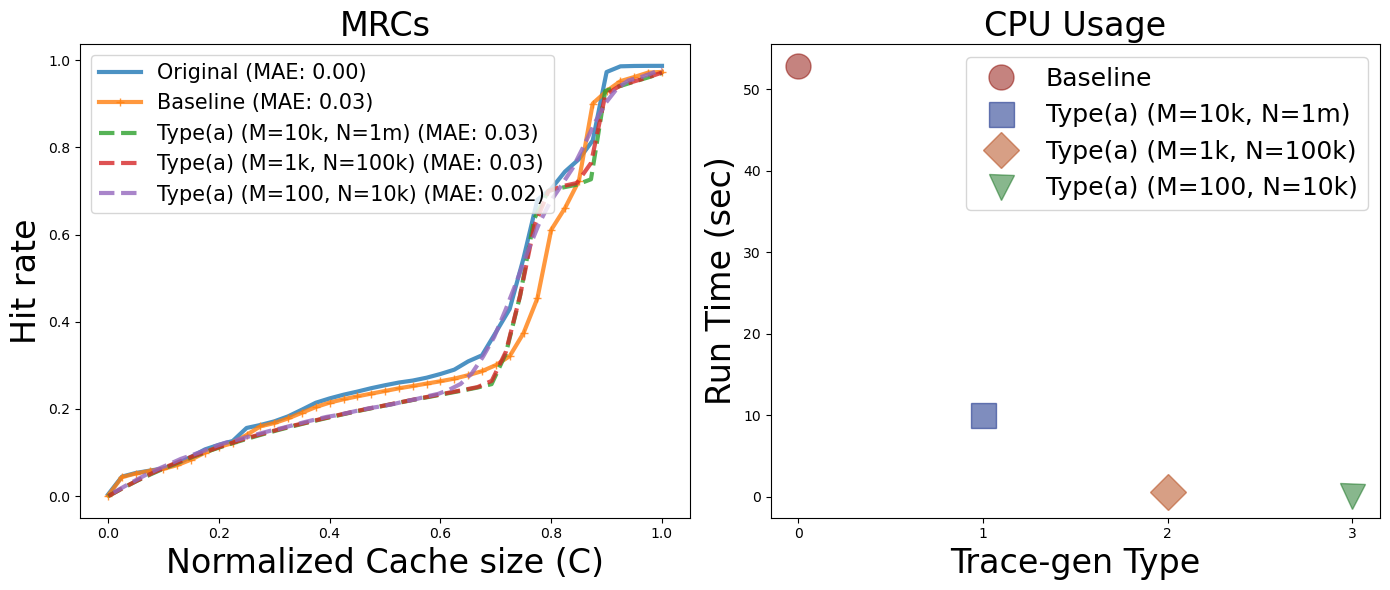

In [28]:
# w82_gen_time = [52.84, 10.03, 6.22, 0.61, 0.06]
w82_gen_time = [52.84, 10.03,0.61, 0.06]
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
# c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
# hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_time([c_82, c_tbl_82, c_ta3_82, c_ta2_82, c_ta1_82], [hr_82, hr_tbl_82, hr_ta3_82, hr_ta2_82, hr_ta1_82], ['Original', 'Baseline', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], gen_time=w82_gen_time)

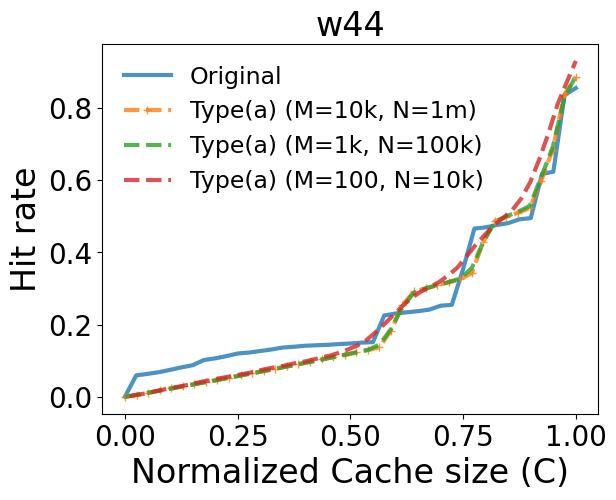

In [48]:
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
# c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
# hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
# c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
# hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrcs([c_44, c_ta3_44, c_ta2_44, c_ta1_44], [hr_44, hr_ta3_44, hr_ta2_44, hr_ta1_44], ['Original', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], 'w44', location='upper left')

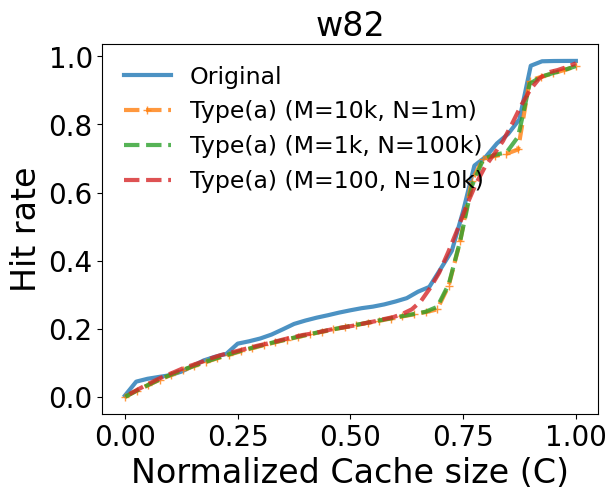

In [49]:
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
# c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
# hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
# c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
# hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)
plot_mrcs([c_82, c_ta3_82, c_ta2_82, c_ta1_82], [hr_82, hr_ta3_82, hr_ta2_82, hr_ta1_82], ['Original', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], 'w82', location='upper left')